<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/aichi/aichi_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!add-apt-repository ppa:alex-p/tesseract-ocr -y

Get:1 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic InRelease [15.4 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Rele

In [2]:
!apt update

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:8 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Building dependency tree  

In [3]:
!apt install tesseract-ocr
!apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libtesseract4 tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following packages will be upgraded:
  libtesseract4
1 upgraded, 3 newly installed, 0 to remove and 46 not upgraded.
Need to get 6,161 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic/main amd64 libtesseract4 amd64 4.1.1-2ppa1~bionic1 [1,261 kB]
Get:2 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic/main amd64 tesseract-ocr-eng all 1:4.0.0+git39-6572757-1ppa1~bionic1 [1,589 kB]
Get:3 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic/main amd64 tesseract-ocr-osd all 1:4.0.0+git39-6572757-1ppa1~bionic1 [2,992 kB]
Get:4 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubunt

In [4]:
!tesseract -v

tesseract 4.1.1-rc2-21-gf4ef
 leptonica-1.78.0
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0
 Found AVX512BW
 Found AVX512F
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.2.2 zlib/1.2.11 liblzma/5.2.2 bz2lib/1.0.6 liblz4/1.7.1


In [5]:
!apt install tesseract-ocr-jpn  tesseract-ocr-jpn-vert
!apt install tesseract-ocr-script-jpan tesseract-ocr-script-jpan-vert

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-jpn tesseract-ocr-jpn-vert
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 3,281 kB of archives.
After this operation, 5,539 kB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic/main amd64 tesseract-ocr-jpn all 1:4.0.0+git39-6572757-1ppa1~bionic1 [1,391 kB]
Get:2 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic/main amd64 tesseract-ocr-jpn-vert all 1:4.0.0+git39-6572757-1ppa1~bionic1 [1,890 kB]
Fetched 3,281 kB in 0s (9,087 kB/s)
Selecting previously unselected package tesseract-ocr-jpn.
(Reading database ... 144609 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-jpn_1%3a4.0.0+git39-6572757-1ppa1~bionic1_all.deb ...
Unpacking tesseract-ocr-jpn (1:4.0.0+git39-6572757-1ppa1~bionic1) ...
Selecting previously

In [6]:
!tesseract --list-langs

List of available languages (6):
Japanese
Japanese_vert
eng
jpn
jpn_vert
osd


# スクレイピング

In [0]:
import pathlib
import re

In [0]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [0]:
url = "https://www.pref.aichi.jp/site/covid19-aichi/"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko",
}

In [0]:
r = requests.get(url, headers=headers)

r.raise_for_status()

soup = BeautifulSoup(r.content, "html5lib")

In [0]:
src = soup.find("img", alt="検査陽性者").get("src")

In [12]:
link = urljoin(url, src)
link

'https://www.pref.aichi.jp/uploaded/image/240274.jpg'

# ダウンロード

In [0]:
def get_file(url, dir="."):

    r = requests.get(url)

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode='wb') as fw:
        fw.write(r.content)

    return p

In [0]:
jpg_path = get_file(link)

# pytesseract

In [15]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=31f6137655b7cc7fcc2bbaea73c79cec57de6787b2392edaa6d2fdd765887b2a
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract


In [0]:
try:
    from PIL import Image
except ImportError:
    import Image
    
import pytesseract

In [0]:
import cv2
import numpy as np

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
# img = cv2.imread(str(jpg_path))
# img, _ = cv2.decolor(img)

In [0]:
src = cv2.imread(str(jpg_path))

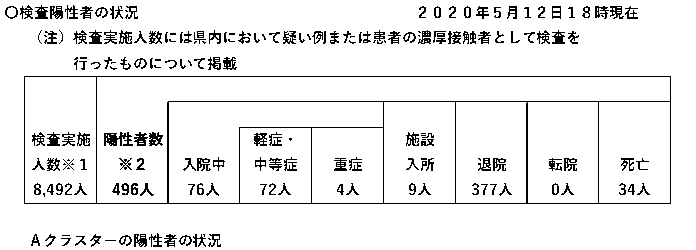

In [21]:
img = cv2.inRange(src, (128, 128, 128), (255, 255, 255))

# 範囲指定
img_crop = img[0:250]

# 確認
cv2_imshow(img_crop)

In [0]:
txt = pytesseract.image_to_string(img_crop, lang="jpn", config="--psm 6")

In [23]:
print(txt)

〇検査陽性者の状況                       2020年5月12日18時現在
(注) 検査実施人数には県内において疑い例または患者の濃厚接触者として検査を
行ったものについて掲載
検査実施 | 隔性者数             軽症・                施設
入数※1| ※2     入院中 | 中等症     重症      入所      退院      転院      死亡
8.492入 | 496人     76人      72人人       4人       9人      377入      0人人      34入
片クラスターの陽性者の状況


In [0]:
data = [int(i.replace(".", "")) for i in re.findall("[0-9.]+", txt)]

In [0]:
result = []

while(len(data) >= 9):

    if data[2] == data[3] + data[4]:
        if data[1] == data[2] + data[5] + data[6] + data[7] + data[8]:
            result = data[:9]
            break

    data.pop(0)

# CSV

In [0]:
import datetime

In [0]:
import csv

In [0]:
dt_match = re.search("(\d{4})年(\d{1,2})月(\d{1,2})日(\d{1,2})時", txt)

In [29]:
if result:

    if dt_match:
        y, m, d, h = map(int, dt_match.groups())
        dt_update = datetime.datetime(y, m, d, h).strftime("%Y%m%d%H00")

        p = pathlib.Path(f'{dt_update}.csv')

        with p.open(mode='w') as fw:
            writer = csv.writer(fw)
            writer.writerow([dt_update] + result)

        print(result)

        jpg_path.rename(f"{dt_update}.jpg")

    else:
        print("見つかりません")   

[8492, 496, 76, 72, 4, 9, 377, 0, 34]
